In [1]:
# 让 Notebook 自动重载本地模块改动（避免手动重启内核）
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.data import load_team_merged_dataframe
from tplc_algo.models import TPLCNet
from tplc_algo.models.layers import (
    DepthwiseSeparableConv2d,
    MultiScaleGenerator,
    extract_topk_periods,
    reshape_1d_to_2d,
    reshape_2d_to_1d,
)
from tplc_algo.pipeline import make_loaders, prepare_greenhouse_datasets
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything

# ======= results / tuner_logs 相关（参考 danshen_GSDAE 结构） =======
from tplc_algo.exp_utils import (
    create_run_dir,
    save_config_json,
    save_env_json,
    save_history_csv,
    save_metrics_json,
    save_figure,
    save_text,
 )
from tplc_algo.tuner import random_search

In [2]:
# ========= 定义改进后的 TPLCNet (RevIN + Embedding) =========

class PositionalEmbedding(nn.Module):
    """位置编码。"""
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    """特征值 Embedding：1D 卷积投影。"""
    def __init__(self, c_in: int, d_model: int) -> None:
        super().__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(
            in_channels=c_in,
            out_channels=d_model,
            kernel_size=3,
            padding=padding,
            padding_mode='circular',
            bias=False
        )
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, C] -> [B, C, T] -> Conv1d -> [B, d_model, T] -> [B, T, d_model]
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

class DataEmbedding(nn.Module):
    """数据 Embedding：特征值 + 位置编码。"""
    def __init__(self, c_in: int, d_model: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, C]
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)

class TPLCNet_Improved(nn.Module):
    """
    改进版 TPLCNet：
    1. 增加 RevIN (可逆实例归一化) 应对非平稳数据
    2. 增加 DataEmbedding 提升特征表达维度
    3. 保留 TPLCNet 的多尺度+DepthSepConv 结构
    """
    def __init__(
        self,
        input_dim: int,
        target_dim: int,
        seq_len: int,
        pred_len: int,
        num_scales: int = 2,
        top_k_periods: int = 3,
        hidden_dim: int = 64,
        dw_kernel: int = 3,
        dropout: float = 0.1
    ) -> None:
        super().__init__()
        self.input_dim = int(input_dim)
        self.target_dim = int(target_dim)
        self.seq_len = int(seq_len)
        self.pred_len = int(pred_len)
        self.num_scales = int(num_scales)
        self.top_k_periods = int(top_k_periods)
        self.hidden_dim = int(hidden_dim)

        # 1. Embedding 层 (改进点 3)
        self.embedding = DataEmbedding(c_in=self.input_dim, d_model=self.hidden_dim, dropout=dropout)

        self.multi_scale = MultiScaleGenerator(num_scales=self.num_scales)
        
        # 卷积输入通道变为 hidden_dim (因为经过了 Embedding)
        self.conv2d = DepthwiseSeparableConv2d(
            in_channels=self.hidden_dim,
            out_channels=self.hidden_dim,
            kernel_size=dw_kernel,
        )

        self.time_projs = nn.ModuleList()
        for m in range(self.num_scales + 1):
            l_m = self.seq_len // (2**m)
            l_m = max(1, l_m)
            self.time_projs.append(nn.Linear(l_m, self.pred_len))
        
        self.channel_proj = nn.Linear(self.hidden_dim, self.target_dim)

        self.scale_logits = nn.Parameter(torch.zeros(self.num_scales + 1))        
        self.dropout = nn.Dropout(p=dropout)
        
        # 残差投影：由于使用了 RevIN，这里的残差对应的是“归一化后的输入”
        # 且输入维度经过 Embedding 变为了 hidden_dim，但这里的残差我们通常使用
        # 原始输入(归一化后)直接映射，或者如果为了保持轻量，可以复用 input_dim
        # 为了与 TPLCNet 原始逻辑（y_sum + x_res）保持一致，我们对归一化后的 x 进行投影
        self.residual_proj = None
        if self.input_dim != self.target_dim:
            self.residual_proj = nn.Linear(self.input_dim, self.target_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, seq_len, input_dim]
        """
        # === 1. RevIN: 归一化 (改进点 1) ===
        means = x.mean(1, keepdim=True).detach()
        x = x - means
        stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x = x / stdev
        # ==================================

        # 保存用于残差连接的 x (已归一化)
        x_residual = x 
        
        # === 2. Embedding ===
        # [B, seq_len, input_dim] -> [B, seq_len, hidden_dim]
        x_emb = self.embedding(x)
        
        # [B, hidden_dim, seq_len]
        x_ct = x_emb.transpose(1, 2).contiguous() 
        scale_list = self.multi_scale(x_ct)

        m_scales = self.num_scales + 1
        scale_weights = torch.softmax(self.scale_logits, dim=0) * float(m_scales)

        y_sum = None
        for m, x_m in enumerate(scale_list):
            # x_m: [B, hidden_dim, Lm]
            period_info = extract_topk_periods(x_m, top_k=self.top_k_periods)
            periods = period_info.periods
            amps = period_info.amplitudes
            weights = torch.softmax(amps, dim=0)

            feats_1d = []
            for k in range(self.top_k_periods):
                p = int(periods[k].item())
                z2d, orig_len = reshape_1d_to_2d(x_m, period=p) 
                y2d = self.conv2d(z2d) 
                y1d = reshape_2d_to_1d(y2d, orig_len=orig_len)
                feats_1d.append(y1d)

            # 多周期融合
            fused = torch.zeros_like(feats_1d[0])
            for k in range(self.top_k_periods):
                fused = fused + weights[k] * feats_1d[k]
            
            fused = self.dropout(fused)

            # 预测头
            l_m = fused.shape[-1]
            expected_lm = self.time_projs[m].in_features
            if l_m > expected_lm:
                fused_use = fused[..., -expected_lm:]
            elif l_m < expected_lm:
                fused_use = F.pad(fused, (expected_lm - l_m, 0), value=0.0)
            else:
                fused_use = fused

            # [B, hidden_dim, pred_len]
            pred_hidden = self.time_projs[m](fused_use)
            pred_hidden = pred_hidden.transpose(1, 2).contiguous() 
            pred_hidden = self.dropout(pred_hidden)
            y_m = self.channel_proj(pred_hidden) # [B, pred_len, target_dim]
            w_m = scale_weights[m]
            y_sum = (w_m * y_m) if y_sum is None else (y_sum + w_m * y_m)

        assert y_sum is not None
        
        # 残差连接 (使用归一化后的 x_residual)
        if self.seq_len >= self.pred_len:
            x_res = x_residual[:, -self.pred_len:, :]
        else:
            x_res = F.pad(x_residual, (0, 0, self.pred_len - self.seq_len, 0))[:, :self.pred_len, :]
        
        if self.residual_proj is not None:
            x_res = self.residual_proj(x_res)
        
        y_sum = y_sum + x_res
        
        # === 3. RevIN: 反归一化 (改进点 1) ===
        # 假设 target_dim 对应输入的前 target_dim 列 (通常情况)
        y_sum = y_sum * (stdev[:, 0, :self.target_dim].unsqueeze(1).repeat(1, self.pred_len, 1))
        y_sum = y_sum + (means[:, 0, :self.target_dim].unsqueeze(1).repeat(1, self.pred_len, 1))
        # ====================================
        
        return y_sum

In [3]:
# ========= 1) 配置 =========
seed_everything(42)

# ========= 数据集选择 =========
# 选项1: 温室挑战赛数据集（多表数据）
# 选项2: 单文件温室数据集
dataset_type = 'single_file'  # 'challenge' 或 'single_file'

if dataset_type == 'challenge':
    # 温室挑战赛数据集
    dataset_root = (Path('..') / 'datasets' / '自主温室挑战赛').resolve()
    team = 'AICU'  # 可改：Reference / IUACAAS / TheAutomators ...
    team_dir = dataset_root / team
    use_single_file = False
elif dataset_type == 'single_file':
    # 单文件温室数据集
    # 注意：dataset_root 是文件所在目录，team 设为 '.' 以便路径拼接正确
    dataset_root = Path(r'D:\学位会\数据集\温室环境数据(4万条)')
    single_file_path = dataset_root / 'GreenhouseClimate1.csv'
    team = '.'  # 使用当前目录，避免额外的子目录
    use_single_file = True
    print('使用单文件数据集:', single_file_path)
else:
    raise ValueError(f"未知的 dataset_type: {dataset_type}")

seq_len = 96   # 约 1 天（5min 频率）
pred_len = 24   # 约 6 小时
stride = 1

num_scales = 2
top_k_periods = 3
hidden_dim = 64

batch_size = 32
epochs = 20
lr = 1e-3
weight_decay = 0.0  # AdamW 的 L2 正则强度（调参会覆盖）

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========= 训练稳定性推荐配置（CUDA 上收益明显） =========
use_amp = (device == 'cuda')
grad_clip_max_norm = 1.0
lr_scheduler = 'plateau'
plateau_patience = 3
plateau_factor = 0.5
early_stop_patience = 6
early_stop_min_delta = 0.0
min_lr = 0.0

# ========= 调参建议（trial epochs 建议 5-10） =========
tune_epochs = 8

# ========= results：每次运行自动创建时间戳目录 =========
exp_name = f"tplcnet_plus_revin_emb_{team}_{dataset_type}"
run_dir = create_run_dir(exp_name)
ckpt_path = run_dir / 'checkpoints' / 'tplcnet_best.pt'
print('device =', device)
if not use_single_file:
    print('team_dir =', team_dir)
print('run_dir =', run_dir)

使用单文件数据集: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
device = cuda
run_dir = D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_plus_revin_emb_._single_file_20260118_134139


In [4]:
# ========= 2) 读取数据 =========
if use_single_file:
    # 单文件数据集
    import pandas as pd
    merged_df = pd.read_csv(single_file_path)
    print('单文件数据集 shape:', merged_df.shape)
    print('columns:', list(merged_df.columns)[:20], '...')
else:
    # 多表数据集
    merged_df = load_team_merged_dataframe(team_dir)
    print('merged_df shape:', merged_df.shape)
    print('columns:', list(merged_df.columns)[:20], '...')
merged_df.head()

单文件数据集 shape: (47809, 50)
columns: ['time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC', 'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR', 'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip', 'co2_dos', 'co2_sp'] ...


,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.000000,439.0,0.48,3.61,96.0,6.96,0.0,50.9,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
1,43815.00347,0.0,85.000001,459.0,0.72,3.61,96.0,7.45,0.0,49.3,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
2,43815.00694,0.0,95.999999,461.0,0.72,3.61,94.6,5.99,0.0,47.6,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
3,43815.01042,0.0,92.000000,465.0,0.72,3.61,94.6,6.57,0.0,46.1,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
4,43815.01389,0.0,92.000000,467.0,0.72,3.62,95.3,6.99,0.0,45.2,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2


In [5]:
# ========= 3) 数据准备（统一走 pipeline：特征筛选 + 标准化 + DataLoader） =========
# 根据数据集类型选择特征
if dataset_type == 'challenge':
    # 温室挑战赛数据集 - 10个核心特征
    selected_features = ['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 
                        'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr']
    print('使用温室挑战赛数据集的10个核心特征')
elif dataset_type == 'single_file':
    # 单文件数据集 - 使用相同的10个核心特征（结构相同）
    selected_features = ['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 
                        'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr']
    print('使用单文件数据集的10个核心特征')
else:
    selected_features = None
    print('使用所有可用特征')

if use_single_file:
    # 单文件数据集需要特殊处理
    prepared = prepare_greenhouse_datasets(
        dataset_root=dataset_root,
        team=team,
        seq_len=seq_len,
        pred_len=pred_len,
        stride=stride,
        base_table='GreenhouseClimate1.csv',  # 指定单文件
        extra_tables=(),  # 不加载额外表
        selected_features=selected_features,
        missing_rate_threshold=0.7,
        drop_constant=True,
        protect_target_cols=True,
    )
else:
    # 多表数据集（温室挑战赛）
    prepared = prepare_greenhouse_datasets(
        dataset_root=dataset_root,
        team=team,
        seq_len=seq_len,
        pred_len=pred_len,
        stride=stride,
        selected_features=selected_features,
        missing_rate_threshold=0.7,
        drop_constant=True,
        protect_target_cols=True,
    )

feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
target_scaler = prepared.target_scaler

train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)

print('input_dim =', len(feature_cols))
print('target_dim =', len(target_cols), target_cols)
print('train batches:', len(train_loader))

使用单文件数据集的10个核心特征
使用 selected_features: 10 个特征
input_dim = 10
target_dim = 3 ['Tair', 'Rhair', 'CO2air']
train batches: 1042


In [6]:
# ========= 6.5) 自动调参（可选） =========
# 兜底：如果你只运行了本单元而没跑“1) 配置”，这里给默认值避免 NameError
if 'weight_decay' not in globals():
    weight_decay = 0.0
if 'tune_epochs' not in globals():
    tune_epochs = 8

enable_tuning = True  # True 启用随机搜索；False 跳过，直接用上面的默认/手动设置超参
max_trials = 15       # 调参次数（建议先小一点）

best_params = {}
tuner_run_dir = None
if enable_tuning:
    # 搜索空间（可按需要扩展/收缩）
    search_space = {
        # 模型超参
        'hidden_dim': [32, 64, 96],
        'top_k_periods': [2, 3, 4],
        'num_scales': [1, 2, 3],
        # 训练超参
        'lr': (5e-4, 3e-3, 'float'),
        'weight_decay': (0.0, 1e-3, 'float'),
    }

    def build_model_fn(params: dict):
        # 注意：这里改为使用 TPLCNet_Improved
        return TPLCNet_Improved(
            input_dim=len(feature_cols),
            target_dim=len(target_cols),
            seq_len=seq_len,
            pred_len=pred_len,
            num_scales=int(params.get('num_scales', num_scales)),
            top_k_periods=int(params.get('top_k_periods', top_k_periods)),
            hidden_dim=int(params.get('hidden_dim', hidden_dim)),
        )

    # 注意：调参日志会写到 TPLC_Net/tuner_logs/ 下
    best_params, trial_results, tuner_run_dir = random_search(
        build_model_fn=build_model_fn,
        train_loader=train_loader,
        val_loader=val_loader,
        search_space=search_space,
        max_trials=max_trials,
        base_seed=42,
        exp_name='tplcnet_improved_search',
        device=device,
        fixed_train_cfg={'epochs': tune_epochs},  # 调参阶段建议 5-10 个 epoch（更稳定）
    )

    print('best_params =', best_params)
    print('tuner_run_dir =', tuner_run_dir)

    # 用最佳超参覆盖后续正式训练配置（非常关键：确保“调参结果真的用上”）
    hidden_dim = int(best_params.get('hidden_dim', hidden_dim))
    top_k_periods = int(best_params.get('top_k_periods', top_k_periods))
    num_scales = int(best_params.get('num_scales', num_scales))
    lr = float(best_params.get('lr', lr))
    weight_decay = float(best_params.get('weight_decay', weight_decay))

    # 调参内部会改变随机种子；这里重置一下，避免正式训练受最后一个 trial 影响
    seed_everything(42)

e:\anaconda\envs\TPLC_Net\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tuning (trial): 100%|##########| 15/15 [27:25<00:00, 109.73s/trial, best=2.1300, last=3.0125]

best_params = {'hidden_dim': 64, 'top_k_periods': 2, 'num_scales': 1, 'lr': 0.0022453484874705673, 'weight_decay': 0.0003402505165179919}
tuner_run_dir = D:\degree_code\scheme_1\TPLC_Net\tuner_logs\tplcnet_improved_search_20260118_134140


In [7]:
# ========= 7) 构建模型并训练 =========
# 改为使用 TPLCNet_Improved
model = TPLCNet_Improved(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    num_scales=num_scales,
    top_k_periods=top_k_periods,
    hidden_dim=hidden_dim,
 )

trainer = Trainer(
    model=model,
    cfg=TrainConfig(
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        device=device,
        ckpt_path=ckpt_path,

        # 稳定性增强
        use_amp=use_amp,
        grad_clip_max_norm=grad_clip_max_norm,
        lr_scheduler=lr_scheduler,
        plateau_patience=plateau_patience,
        plateau_factor=plateau_factor,
        early_stop_patience=early_stop_patience,
        early_stop_min_delta=early_stop_min_delta,
        min_lr=min_lr,

        show_progress=True,
        progress_granularity='batch',
    )
 )
history = trainer.fit(train_loader, val_loader=val_loader)

# ===== 保存本次运行配置/环境/训练曲线 =====
config_payload = {
    'team': team,
    'dataset_root': str(dataset_root),
    'seq_len': seq_len,
    'pred_len': pred_len,
    'stride': stride,
    'feature_cols': feature_cols,
    'target_cols': target_cols,
    'model': {
        'num_scales': num_scales,
        'top_k_periods': top_k_periods,
        'hidden_dim': hidden_dim,
        'note': 'TPLCNet_Improved with RevIN and Embedding'
    },
    'train': {
        'batch_size': batch_size,
        'epochs': epochs,
        'lr': lr,
        'weight_decay': weight_decay,
        'device': device,
        'use_amp': use_amp,
    }
}
save_config_json(run_dir, config_payload)
save_env_json(run_dir)
save_history_csv(run_dir, history)

print(f'\n训练完成！结果保存到：{run_dir}')

train (epoch):  30%|###       | 6/20 [01:35<03:41, 15.85s/epoch, train=0.6129, val=3.8438, stop=best@1]


训练完成！结果保存到：D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_plus_revin_emb_._single_file_20260118_134139


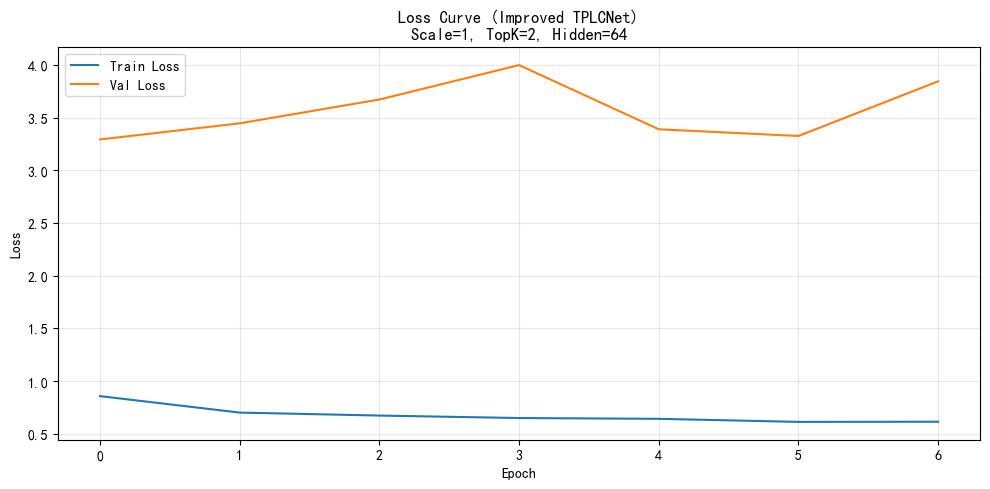

In [8]:
# ========= 8) 可视化：Loss 曲线 =========
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['train_loss'], label='Train Loss')
if 'val_loss' in history:
    ax.plot(history['val_loss'], label='Val Loss')
ax.set_title(f'Loss Curve (Improved TPLCNet)\nScale={num_scales}, TopK={top_k_periods}, Hidden={hidden_dim}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'loss_curve.png')
plt.show()

In [9]:
# ========= 9) 验证集/测试集指标 =========
metrics = trainer.evaluate(test_loader)
print('Test Metrics:', metrics)
save_metrics_json(run_dir, metrics)

# 保存到文本报告
report = f"""
Experiment: {exp_name}
Model: TPLCNet_Improved (RevIN + Embedding)
SeqLen: {seq_len}, PredLen: {pred_len}
Test Metrics:
MAE: {metrics.get('mae', -1):.4f}
MSE: {metrics.get('mse', -1):.4f}
RMSE: {metrics.get('rmse', -1):.4f}
MAPE: {metrics.get('mape', -1):.4f}
"""
print(report)
save_text(run_dir / 'report.txt', report)

Test Metrics: {'loss': 3.7518693756521984, 'mae': 1.4141964967954668, 'rmse': 1.7636465039711693}

Experiment: tplcnet_plus_revin_emb_._single_file
Model: TPLCNet_Improved (RevIN + Embedding)
SeqLen: 96, PredLen: 24
Test Metrics:
MAE: 1.4142
MSE: -1.0000
RMSE: 1.7636
MAPE: -1.0000



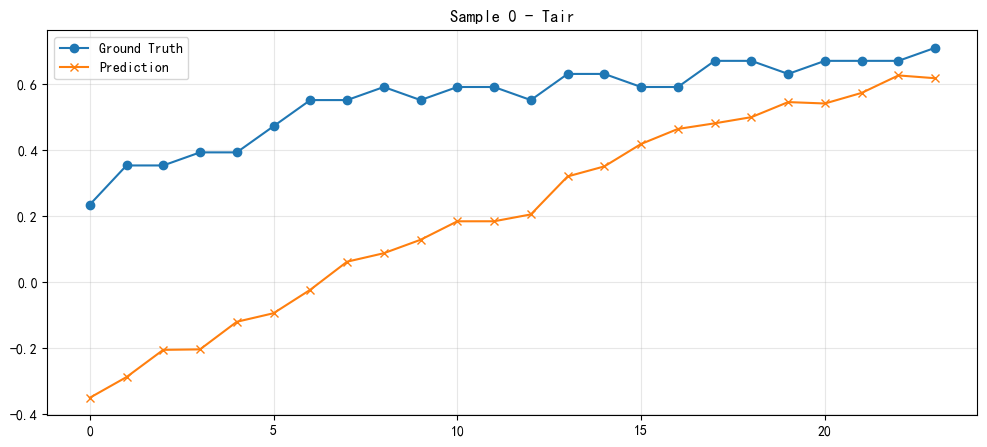

In [10]:
# ========= 10) 预测结果可视化（随机抽样） =========
model.eval()
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    y_pred = model(x_batch).cpu()

# 可视化前几个样本的第一个变量
# 注意：数据已标准化，这里为了看趋势直接画，如需真实值需反标准化 (dataset.scaler.inverse_transform)
# 但 prepared.target_scaler 是针对全量的，这里简化处理只看 shape 和趋势
idx_sample = 0
idx_target = 0 # 选择第0个预测目标
var_name = target_cols[idx_target]

fig, ax = plt.subplots(figsize=(12, 5))
# 真实值 (seq + pred) -> 我们只有 pred_len 的真实值 y_batch
# 一般可视化会将 input 和 output 连起来看，但 input x 是多变量且可能与 y 及其不同
# 这里只画 y_true 和 y_pred

y_t = y_batch[idx_sample, :, idx_target]
y_p = y_pred[idx_sample, :, idx_target]

ax.plot(y_t, marker='o', label='Ground Truth')
ax.plot(y_p, marker='x', label='Prediction')
ax.set_title(f'Sample {idx_sample} - {var_name}')
ax.legend()
ax.grid(alpha=0.3)
save_figure(fig, run_dir / 'figures' / 'prediction_sample.png')
plt.show()